In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob

import xarray as xr
import numpy as np

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
import math

## work on resource competition, parameter values from 4P4Z CESM2

#### define Tfunc parameters -- we'll use a temp of 15°C

In [92]:
### Specify Tfunc
T = 15.
Tref = 30.
q10 = 1.7
Tfunc = q10**((T - Tref) / 10.)

Tfunc_power = 0.12 * T**0.4

#### assume that Fe is the limiting nutrient (used in both the nutrient lim term and light lim term)

In [93]:
kFe_diat = 5.e-5
kFe_sp = 3.e-5
kFe_cocco = 5.e-5

#### define other parameters

In [94]:
alpha_pi_diat = 0.39
alpha_pi_sp = 0.35
alpha_pi_cocco = 0.3

thetaN_max_diat = 4
thetaN_max_sp = 2.5
thetaN_max_cocco = 3.5

NtoC = 0.137

thetaC_diat = thetaN_max_diat * NtoC
thetaC_sp = thetaN_max_sp * NtoC
thetaC_cocco = thetaN_max_cocco * NtoC

PCref_diat = 5.3
PCref_sp = 4.8
PCref_cocco = 4.7

#### create empty matrices and define ranges for [Fe] amd PAR

In [95]:
sp_growthrate = np.full((100,100),np.nan)
diat_growthrate = np.full((100,100),np.nan)
cocco_growthrate = np.full((100,100),np.nan)

#Fe_vals = np.arange(0.00001,0.0010001,0.00001)
#Fe_vals = np.arange(0.0001,0.01001,0.0001)
Fe_vals = np.arange(0.000001,0.0001,0.000001)
PAR_vals = np.arange(0.5,50.5,0.5)

In [96]:
len(Fe_vals)

100

#### cycle through values and calculate growth rate for sp and diat, taking difference

In [97]:
i=0
j=0

for Fe in Fe_vals: # i loop
    
    for PAR in PAR_vals: # j loop
        
        ##### small phytoplankton
        sp_nut_lim = Fe/(Fe + kFe_sp)
        sp_light_lim = 1 - math.e ** ((-1. * alpha_pi_sp * thetaC_sp * PAR) / (PCref_sp * Tfunc * sp_nut_lim))
        
        sp_growthrate[j,i] = PCref_sp * Tfunc * sp_nut_lim * sp_light_lim
        
        #### diatoms
        diat_nut_lim = Fe/(Fe + kFe_diat)
        diat_light_lim = 1 - math.e ** ((-1. * alpha_pi_diat * thetaC_diat * PAR) / (PCref_diat * Tfunc * diat_nut_lim))
        
        diat_growthrate[j,i] = PCref_diat * Tfunc * diat_nut_lim * diat_light_lim
        
        #### coccolithophores
        cocco_nut_lim = Fe/(Fe + kFe_cocco)
        cocco_light_lim = 1 - math.e ** ((-1. * alpha_pi_cocco * thetaC_cocco * PAR) / (PCref_cocco * Tfunc_power *  cocco_nut_lim))
        
        cocco_growthrate[j,i] = PCref_cocco * Tfunc_power * cocco_nut_lim * cocco_light_lim
        
        j = j + 1
        
    i = i + 1
    j = 0

In [98]:
sp_growthrate = xr.DataArray(sp_growthrate,dims=('par_vals','fe_vals'))
diat_growthrate = xr.DataArray(diat_growthrate,dims=('par_vals','fe_vals'))
cocco_growthrate = xr.DataArray(cocco_growthrate,dims=('par_vals','fe_vals'))

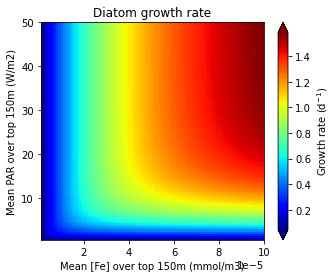

In [99]:
fig = plt.figure(figsize=(5,4))

ax = fig.add_subplot(1,1,1)

ax.set_title('Diatom growth rate')
pc=ax.pcolormesh(Fe_vals, PAR_vals, diat_growthrate,cmap='jet')
ax.set_ylabel('Mean PAR over top 150m (W/m2)')
ax.set_xlabel('Mean [Fe] over top 150m (mmol/m3)')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)');

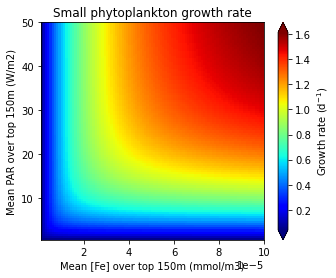

In [100]:
fig = plt.figure(figsize=(5,4))

ax = fig.add_subplot(1,1,1)

ax.set_title('Small phytoplankton growth rate')
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate,cmap='jet')
ax.set_ylabel('Mean PAR over top 150m (W/m2)')
ax.set_xlabel('Mean [Fe] over top 150m (mmol/m3)')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)');

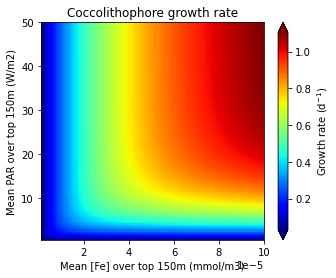

In [101]:
fig = plt.figure(figsize=(5,4))

ax = fig.add_subplot(1,1,1)

ax.set_title('Coccolithophore growth rate')
pc=ax.pcolormesh(Fe_vals, PAR_vals, cocco_growthrate,cmap='jet')
ax.set_ylabel('Mean PAR over top 150m (W/m2)')
ax.set_xlabel('Mean [Fe] over top 150m (mmol/m3)')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate (d$^{-1}$)');

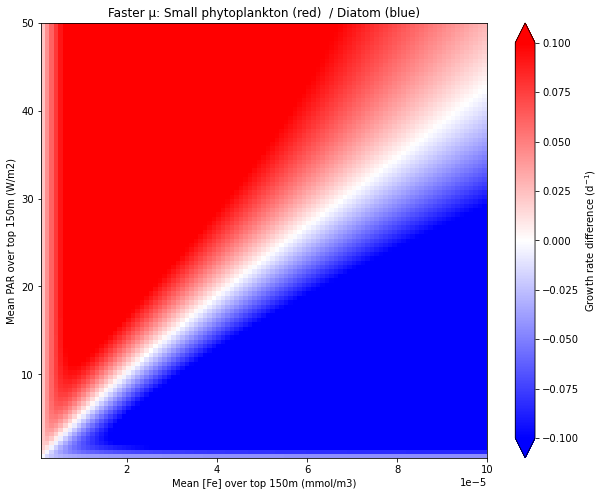

In [102]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1)

ax.set_title('Faster µ: Small phytoplankton (red)  / Diatom (blue)')
pc=ax.pcolormesh(Fe_vals, PAR_vals, sp_growthrate-diat_growthrate,cmap='bwr',vmin=-0.1,vmax=0.1)
ax.set_ylabel('Mean PAR over top 150m (W/m2)')
ax.set_xlabel('Mean [Fe] over top 150m (mmol/m3)')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate difference (d$^{-1}$)');

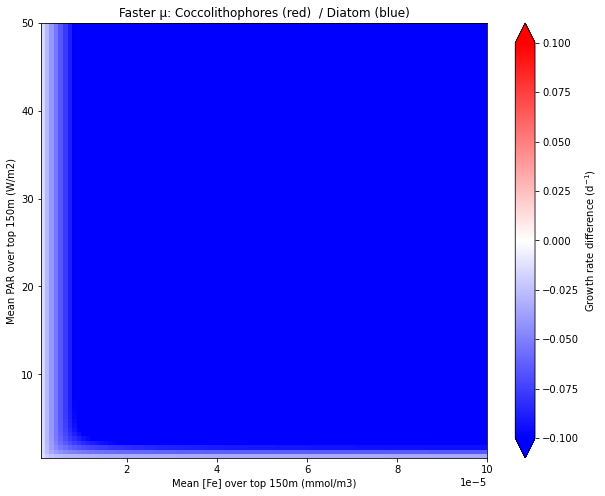

In [103]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1)

ax.set_title('Faster µ: Coccolithophores (red)  / Diatom (blue)')
pc=ax.pcolormesh(Fe_vals, PAR_vals, cocco_growthrate-diat_growthrate,cmap='bwr',vmin=-0.1,vmax=0.1)
ax.set_ylabel('Mean PAR over top 150m (W/m2)')
ax.set_xlabel('Mean [Fe] over top 150m (mmol/m3)')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate difference (d$^{-1}$)');

### but what if it's an SiO3-limited region?

In [104]:
kSiO3_diat = 1.6
kSiO3_sp = 0.
kSiO3_cocco = 0.

In [105]:
sp_growthrate = np.full((100,100),np.nan)
diat_growthrate = np.full((100,100),np.nan)
cocco_growthrate = np.full((100,100),np.nan)

#Fe_vals = np.arange(0.00001,0.0010001,0.00001)
#Fe_vals = np.arange(0.0001,0.01001,0.0001)
Si_vals = np.arange(0.1,10.1,0.1)
PAR_vals = np.arange(0.5,50.5,0.5)

In [106]:
i=0
j=0

for Si in Si_vals: # i loop
    
    for PAR in PAR_vals: # j loop
        
        ##### small phytoplankton
        sp_nut_lim = Si/(Si + kSiO3_sp)
        sp_light_lim = 1 - math.e ** ((-1. * alpha_pi_sp * thetaC_sp * PAR) / (PCref_sp * Tfunc * sp_nut_lim))
        
        sp_growthrate[j,i] = PCref_sp * Tfunc * sp_nut_lim * sp_light_lim
        
        #### diatoms
        diat_nut_lim = Si/(Si + kSiO3_diat)
        diat_light_lim = 1 - math.e ** ((-1. * alpha_pi_diat * thetaC_diat * PAR) / (PCref_diat * Tfunc * diat_nut_lim))
        
        diat_growthrate[j,i] = PCref_diat * Tfunc * diat_nut_lim * diat_light_lim
        
        #### coccolithophores
        cocco_nut_lim = Si/(Si + kSiO3_cocco)
        cocco_light_lim = 1 - math.e ** ((-1. * alpha_pi_cocco * thetaC_cocco * PAR) / (PCref_cocco * Tfunc_power *  cocco_nut_lim))
        
        cocco_growthrate[j,i] = PCref_cocco * Tfunc_power * cocco_nut_lim * cocco_light_lim
        
        j = j + 1
        
    i = i + 1
    j = 0

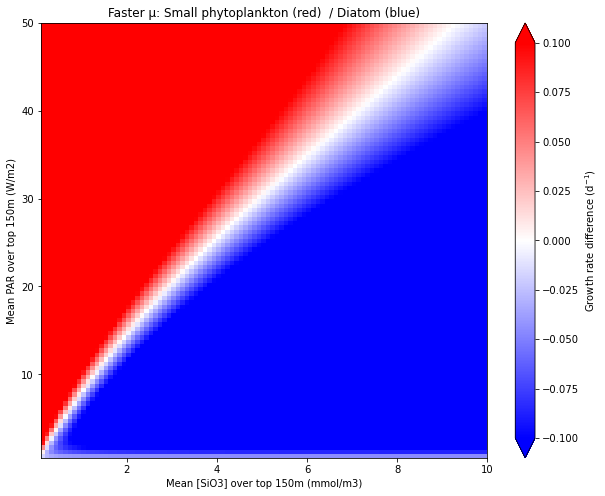

In [107]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1)

ax.set_title('Faster µ: Small phytoplankton (red)  / Diatom (blue)')
pc=ax.pcolormesh(Si_vals, PAR_vals, sp_growthrate-diat_growthrate,cmap='bwr',vmin=-0.1,vmax=0.1)
ax.set_ylabel('Mean PAR over top 150m (W/m2)')
ax.set_xlabel('Mean [SiO3] over top 150m (mmol/m3)')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate difference (d$^{-1}$)');

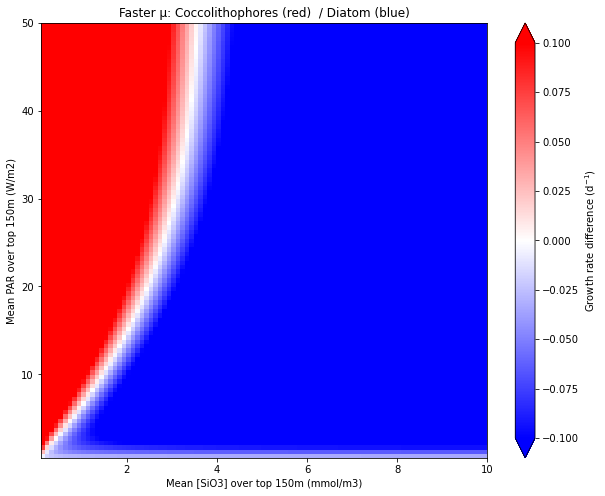

In [108]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1)

ax.set_title('Faster µ: Coccolithophores (red)  / Diatom (blue)')
pc=ax.pcolormesh(Si_vals, PAR_vals, cocco_growthrate-diat_growthrate,cmap='bwr',vmin=-0.1,vmax=0.1)
ax.set_ylabel('Mean PAR over top 150m (W/m2)')
ax.set_xlabel('Mean [SiO3] over top 150m (mmol/m3)')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate difference (d$^{-1}$)');

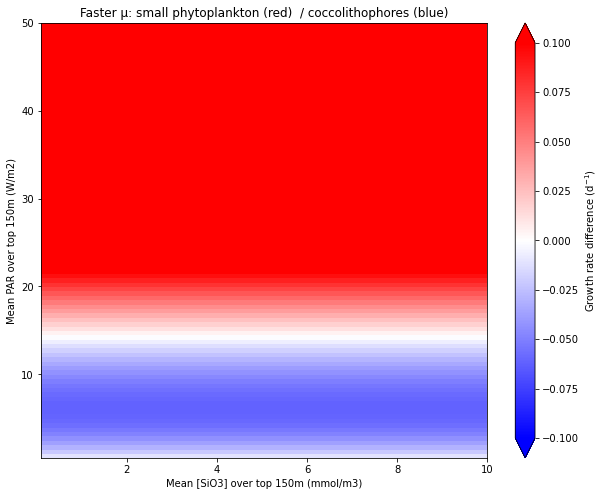

In [109]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(1,1,1)

ax.set_title('Faster µ: small phytoplankton (red)  / coccolithophores (blue)')
pc=ax.pcolormesh(Si_vals, PAR_vals, sp_growthrate-cocco_growthrate,cmap='bwr',vmin=-0.1,vmax=0.1)
ax.set_ylabel('Mean PAR over top 150m (W/m2)')
ax.set_xlabel('Mean [SiO3] over top 150m (mmol/m3)')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Growth rate difference (d$^{-1}$)');

#in this case neither sp or cocco are nutrient limited